In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt

# --- 中文顯示設定 ---
# 加上這兩行來正常顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 指定支援中文的字體
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題
# ---

# ... 接著是您其他的 import 和程式碼 ...
# import os
# import numpy as np
# from PIL import Image

In [8]:
# ==================================
#         專案設定 (CONFIGURATION)
# ==================================
# 影片存放的資料夾
VIDEO_DIR = "./videos"

# 要處理的影片檔名
# 【關鍵】以後要換影片，只需要修改這一行！
VIDEO_FILENAME = "traffic_3.mp4" 

# 要使用的 YOLOv8 模型
MODEL_NAME = 'yolov8n.pt'
# ==================================

In [11]:
import cv2
import os
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# --- 1. 基礎設定 ---
# --- 讀取設定 ---
# 程式碼會從上面的「設定區塊」讀取參數，而不是寫死在裡面
VIDEO_PATH = os.path.join(VIDEO_DIR, VIDEO_FILENAME)

# 我們只對 COCO 資料集中特定的類別感興趣，例如：
# 2='car', 3='motorcycle', 5='bus', 7='truck'
TARGET_CLASSES = [0, 2, 3, 5, 7]
# 偵測信心度門檻
CONFIDENCE_THRESHOLD = 0.4

# 載入 YOLOv8 模型
model = YOLO(MODEL_NAME) 

# 初始化 DeepSORT 追蹤器
# max_age: 一個物體在多少幀內未被偵測到，就會被認定為消失
tracker = DeepSort(max_age=30)

# --- 2. 讀取影片並進行追蹤 ---
cap = cv2.VideoCapture(VIDEO_PATH)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # --- 偵測 ---
    # 在當前幀上執行 YOLOv8 偵測
    # 我們只偵測我們感興趣的類別
    results = model(frame, classes=TARGET_CLASSES, verbose=False)

    # --- 格式轉換 ---
    # 建立一個列表，用來存放 DeepSORT 需要的偵測結果
    detections = []
    # 遍歷 YOLOv8 的偵測結果
    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0] # 邊界框座標
        confidence = result.conf[0]    # 信心度
        class_id = int(result.cls[0])  # 類別 ID
        
        # 只處理信心度高於門檻的結果
        if confidence > CONFIDENCE_THRESHOLD:
            # DeepSORT 需要的格式是：([left, top, width, height], confidence, class)
            bbox = [int(x1), int(y1), int(x2 - x1), int(y2 - y1)]
            detections.append((bbox, confidence, model.names[class_id]))

    # --- 追蹤 ---
    # 使用 DeepSORT 更新追蹤器
    # tracks 是當前幀中所有被追蹤的物體的列表
    tracks = tracker.update_tracks(detections, frame=frame)

    # --- 視覺化 (更新版) ---
    # 遍歷所有被追蹤的物體
    for track in tracks:
        # is_confirmed() 代表這個物體的追蹤狀態是否已經穩定
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id      # 取得追蹤 ID
        ltrb = track.to_ltrb()         # 取得邊界框座標 (left, top, right, bottom)
        class_name = track.get_det_class() # 【新】取得物體類別名稱
        
        # 組合要顯示的文字
        label = f"{class_name} ID: {track_id}" # 【新】組合標籤文字
        
        # 畫出邊界框
        cv2.rectangle(frame, (int(ltrb[0]), int(ltrb[1])), (int(ltrb[2]), int(ltrb[3])), (0, 255, 0), 2)
        # 畫出組合後的文字
        cv2.putText(frame, label, (int(ltrb[0]), int(ltrb[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # 顯示結果
    cv2.imshow("YOLOv8 + DeepSORT", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

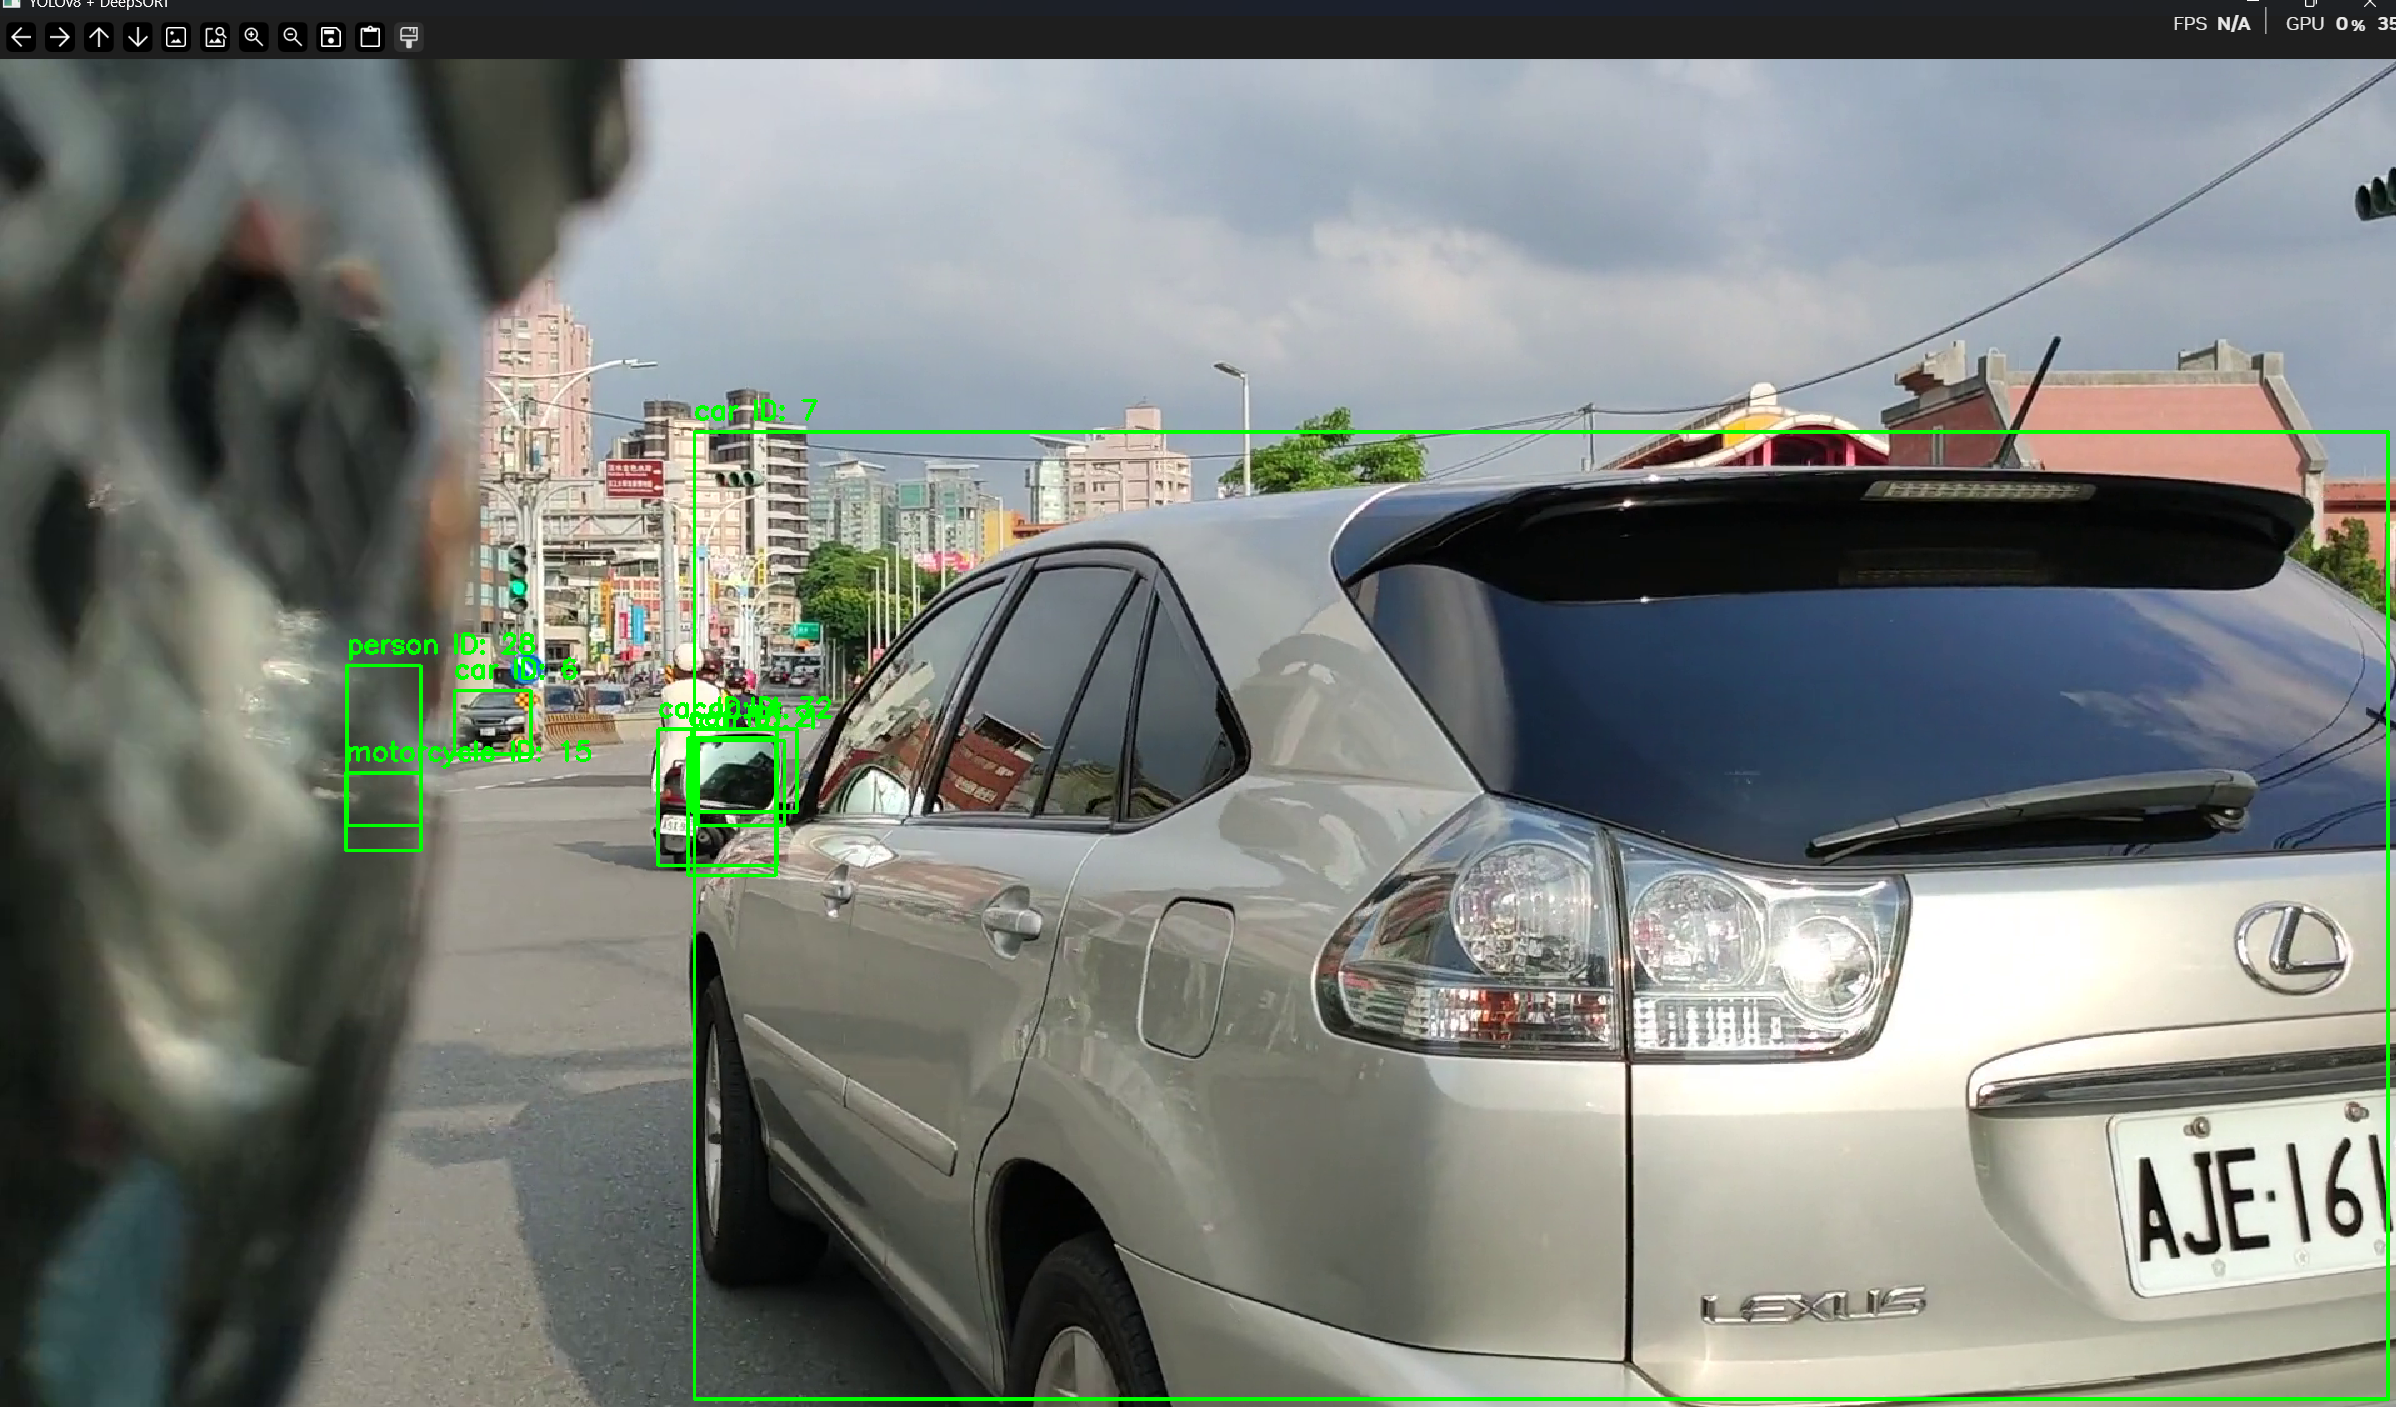